#  Imports


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import Xception, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.metrics import f1_score


import seaborn as sns
import matplotlib.pyplot as plt
import os

# Function Definitions

In [2]:
def train_val_generators(train_dir, val_dir):
    train_gen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, vertical_flip=True, zoom_range=0.2)
    train_generator = train_gen.flow_from_directory(directory=train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

    val_gen = ImageDataGenerator(rescale=1/255.)
    val_generator = val_gen.flow_from_directory(directory=val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

    return train_generator, val_generator


def train_model(model, train_generator, val_generator, epochs=15):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[callback])

    return history


In [3]:
def assign_labels(test_generator, model, print_info=True):
    test_labels = []
    pred_labels = []

    for batch in range(0, int(len(test_generator))):
        batch_predicted = model.predict(test_generator[batch][0])
        for i in range(len(batch_predicted)):
            pred_label = np.argmax(batch_predicted[i])
            true_label = np.argmax(test_generator[batch][1][i])
            true_name = bc_types[true_label]  # Decode true label to category
            pred_name = bc_types[pred_label]  # Decode predicted label to category
            true_category = dict_bc[bc_dict[true_name]]  # Use bc_dict to get the value and then access dict_bc
            pred_category = dict_bc[bc_dict[pred_name]]  # Use bc_dict to get the value and then access dict_bc

            pred_labels.append(pred_category)
            test_labels.append(true_category)

            if print_info:
                print(f"Imagen {batch * len(batch_predicted) + i + 1} - Verdadero: {true_category} ( {true_name} ), Predicho: {pred_category} ( {pred_name} )")

    return test_labels, pred_labels

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plotear el historial de entrenamiento
    eps = range(len(history.history["loss"]))
    plt.figure(figsize=(10, 6))
    plt.plot(eps, history.history["loss"])
    plt.plot(eps, history.history["val_loss"])
    plt.legend(["loss", "val_loss"])
    plt.title('Training History - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # Plotear la precisión
    plt.figure(figsize=(10, 6))
    plt.plot(eps, history.history["accuracy"])
    plt.plot(eps, history.history["val_accuracy"])
    plt.legend(["accuracy", "val_accuracy"])
    plt.title('Training History - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def check_precision(model, test_generator):
    # Asignar e imprimir etiquetas
    test_labels, pred_labels = assign_labels(test_generator, model, print_info=False)

    # Imprimir la matriz de confusión y la precisión
    cm = confusion_matrix(test_labels, pred_labels)
    accuracy = accuracy_score(test_labels, pred_labels)

    print("Matriz de Confusión:")
    print(cm)
    print("Precisión:", accuracy)
    return cm





In [5]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    plt.show()

# Configuracion inicial

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

# Directorio base después de montar el drive
base_path = '/content/drive/My Drive/DataSet'

# Listar archivos en el directorio base
files = os.listdir(base_path)

path_root = '/content/drive/My Drive/DataSet'

valid_dir = os.path.join(path_root, 'val')
train_dir = os.path.join(path_root, 'train')
test_dir = os.path.join(path_root, 'test')

In [8]:
bc_types = [file for file in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, file))]
print("Types: ", bc_types)

# to encode labels
bc_dict = {'InSitu': 3, 'Benign': 2, 'Normal': 1, 'Invasive': 4}
print("Encode: ", bc_dict)

# to decode labels
dict_bc = {1: "Normal", 2: "Benign", 3: "InSitu", 4: "Invasive"}
print("Decode: ", dict_bc)

classes = [dict_bc[i] for i in sorted(dict_bc.keys())]


Types:  ['InSitu', 'Normal', 'Invasive', 'Benign']
Encode:  {'InSitu': 3, 'Benign': 2, 'Normal': 1, 'Invasive': 4}
Decode:  {1: 'Normal', 2: 'Benign', 3: 'InSitu', 4: 'Invasive'}


In [9]:
# Set IMG_SIZE and BATCH_SIZE
IMG_SIZE = (384,512)

BATCH_SIZE = 16
NUM_CLASES = 4

In [ ]:
import imghdr  # Importar el módulo imghdr para verificar el tipo de imagen

# Calcular el rango de píxeles en lugar de asumir que es 255
pixel_min = float('inf')  # Inicializar con un valor grande
pixel_max = float('-inf')  # Inicializar con un valor pequeño

# Iterar sobre las imágenes en el conjunto de entrenamiento para encontrar el rango real
for root, dirs, files in os.walk(train_dir):
    for file in files:
        img_path = os.path.join(root, file)

        # Verificar si el archivo es una imagen
        if imghdr.what(img_path) is not None:
            img = plt.imread(img_path)
            img_min = np.min(img)
            img_max = np.max(img)
            pixel_min = min(pixel_min, img_min)
            pixel_max = max(pixel_max, img_max)

In [ ]:
pixel_min

0

In [ ]:
train_generator, val_generator = train_val_generators(train_dir, valid_dir)   # create image generators to feed images to the model


Found 236 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


# Create models

In [ ]:
#Para poder incluir el valor f1 en el entrenamiento del modelo creamos las siguientes
#funciones para añadirlo como una función siguiendo la referencia del sigueinte enlace
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



## Xcepcion

In [ ]:
def create_model_Xception(base_model, learning_rate, optimizer='adamax'):
    # Function for creating an Xception-based model with specific architecture and settings
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='AUC'),
    ]

    model = Sequential([
        base_model,
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(4, activation="softmax"),
    ])
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])

    return model

In [15]:

def create_model_Xception_unfreeze(base_model, learning_rate, optimizer='adamax'):
    # Function for creating an Xception-based model with specific architecture and settings
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='AUC'),
    ]

# Congelar capas preentrenadas
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(4, activation="softmax"),
    ])
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])

    return model

In [ ]:
xception_base_model = tf.keras.applications.Xception(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False)

xception_model = create_model_Xception(xception_base_model,0.001)
xception_model_lr2 = create_model_Xception(xception_base_model,0.0001)


In [ ]:
# Mostrar información sobre las capas
for i, layer in enumerate(xception_model.layers):
    print(f"Capa {i + 1}: {layer.name}")
    print(f"  - Dimensión de Entrada: {layer.input_shape}")
    print(f"  - Dimensión de Salida: {layer.output_shape}")
    print("=" * 40)

In [17]:
xception_model_unfreeze = create_model_Xception_unfreeze(xception_base_model,0.001)


## ResNet

# EfficientB0

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

def create_model_efficientnetb0(num_classes, img_size1, img_size2):
    inputs = layers.Input(shape=(img_size1, img_size2, 3))

    # EfficientNetB0 como modelo base
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name="avg_pool"),
        layers.BatchNormalization(),
        layers.Dropout(0.2, name="top_dropout"),
        layers.Dense(num_classes, activation="softmax", name="pred"),
    ], name="CustomEfficientNetB0")

    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc', f1_m, precision_m, recall_m])

    return model




In [19]:
model_EfficientNetB0_1 = create_model_efficientnetb0(4, IMG_SIZE[0], IMG_SIZE[1])



16705208/16705208 [==============================] - 0s 0us/step


In [20]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

def build_model_V3(num_classes,img_size1,img_size2):
    inputs = layers.Input(shape=(img_size1,img_size2, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = InceptionV3(weights='imagenet',input_tensor=x,include_top=False,input_shape=(img_size1,img_size2,3))

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(4, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="V3")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc',f1_m,precision_m, recall_m]
    )
    return model



In [21]:
model_V3 = build_model_V3(4,IMG_SIZE[0], IMG_SIZE[1])



87910968/87910968 [==============================] - 45s 1us/step


## VGG

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model_VGG16(input_shape1, input_shape2, num_classes=4):
    # Cargar el modelo VGG16 preentrenado sin la capa densa superior (include_top=False)
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(input_shape1, input_shape2, 3))

    # Congelar las capas convolucionales preentrenadas
    for layer in base_model.layers:
        layer.trainable = False

    # Agregar capas personalizadas para la clasificación
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo personalizado
    custom_model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar el modelo con el optimizador Adam y pérdida categórica entropía cruzada
    custom_model.compile(optimizer=Adam(learning_rate=0.0002),
                        loss='categorical_crossentropy',
                        metrics=['acc',f1_m,precision_m, recall_m])

    return custom_model




In [23]:

model_vgg16 = build_model_VGG16(IMG_SIZE[0], IMG_SIZE[1],4)


58889256/58889256 [==============================] - 0s 0us/step


In [24]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model_VGG19(input_shape1, input_shape2, num_classes=4):
    # Cargar el modelo VGG19 preentrenado sin la capa densa superior (include_top=False)
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(input_shape1, input_shape2, 3))

    # Congelar las capas convolucionales preentrenadas
    for layer in base_model.layers:
        layer.trainable = False

    # Agregar capas personalizadas para la clasificación
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo personalizado
    custom_model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar el modelo con el optimizador Adam y pérdida categórica entropía cruzada
    custom_model.compile(optimizer=Adam(learning_rate=0.0002),
                        loss='categorical_crossentropy',
                        metrics=['acc',f1_m,precision_m, recall_m])

    return custom_model



In [25]:
model_vgg19 = build_model_VGG19(IMG_SIZE[0], IMG_SIZE[1],4)


80134624/80134624 [==============================] - 1s 0us/step


## resnet

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model_resnet(input_shape1, input_shape2, num_classes=4):
    # Cargar el modelo ResNet50 preentrenado sin la capa densa superior (include_top=False)
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(input_shape1, input_shape2, 3))


    # Agregar capas personalizadas para la clasificación
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo personalizado
    custom_model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar el modelo con el optimizador Adam y pérdida categórica entropía cruzada
    custom_model.compile(optimizer=Adam(learning_rate=0.0002),
                        loss='categorical_crossentropy',
                        metrics=['acc',f1_m,precision_m, recall_m])

    return custom_model




In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model_resnet2(input_shape1, input_shape2, num_classes=4):
    # Cargar el modelo ResNet50 preentrenado sin la capa densa superior (include_top=False)
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(input_shape1, input_shape2, 3))


    # Agregar capas personalizadas para la clasificación
    x = GlobalAveragePooling2D()(base_model.output)
    x = Flatten()(x)  # Aplanar los datos si la salida de GlobalAveragePooling2D es rectangular
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo personalizado
    custom_model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar el modelo con el optimizador Adam y pérdida categórica entropía cruzada
    custom_model.compile(optimizer=Adam(learning_rate=0.0002),
                        loss='categorical_crossentropy',
                        metrics=['acc',f1_m,precision_m, recall_m])

    return custom_model




In [28]:
IMG_SIZE

(384, 512)

In [29]:
model_resnet = build_model_resnet(IMG_SIZE[0], IMG_SIZE[1],4)


94765736/94765736 [==============================] - 0s 0us/step


In [30]:
model_resnet2 = build_model_resnet2(IMG_SIZE[0], IMG_SIZE[1],4)


In [31]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

def build_model_V3(num_classes,img_size1,img_size2):
    inputs = layers.Input(shape=(img_size1,img_size2, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = InceptionV3(weights='imagenet',input_tensor=x,include_top=False,input_shape=(img_size1,img_size2,3))

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(4, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="V3")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc',f1_m,precision_m, recall_m]
    )
    return model



# Entrenamiento de modelos

In [32]:
train_gen, val_gen = train_val_generators(train_dir, valid_dir)


Found 236 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)   # limitation to stop somewhere early


In [34]:
%%time

print("\n[INFO] Ready to train. Training is starting!\n")
BATCH_SIZE = 8
train_gen, val_gen = train_val_generators(train_dir, valid_dir)   # create image generators to feed images to the model

hist_xception = xception_model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[callback])



[INFO] Ready to train. Training is starting!

Found 236 images belonging to 4 classes.
Found 81 images belonging to 4 classes.
Epoch 1/25
30/30 [==============================] - 96s 2s/step - loss: 1.7340 - acc: 0.3814 - f1_m: 0.3242 - precision_m: 0.3823 - recall_m: 0.2875 - val_loss: 2.3248 - val_acc: 0.2469 - val_f1_m: 0.2275 - val_precision_m: 0.2597 - val_recall_m: 0.2045
Epoch 2/25
30/30 [==============================] - 18s 591ms/step - loss: 1.2158 - acc: 0.4958 - f1_m: 0.4555 - precision_m: 0.5448 - recall_m: 0.4042 - val_loss: 1.6665 - val_acc: 0.3580 - val_f1_m: 0.2537 - val_precision_m: 0.3970 - val_recall_m: 0.1932
Epoch 3/25
30/30 [==============================] - 18s 596ms/step - loss: 0.9948 - acc: 0.6102 - f1_m: 0.5953 - precision_m: 0.6947 - recall_m: 0.5292 - val_loss: 1.4611 - val_acc: 0.4444 - val_f1_m: 0.4298 - val_precision_m: 0.5848 - val_recall_m: 0.3636
Epoch 4/25
30/30 [==============================] - 19s 612ms/step - loss: 0.7005 - acc: 0.7331 - f1_m: 

In [37]:

%%time

print("\n[INFO] Ready to train. Training is starting!\n")

hist_v3 = model_V3.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[callback])



[INFO] Ready to train. Training is starting!

Epoch 1/25
30/30 [==============================] - 26s 633ms/step - loss: 1.6406 - acc: 0.3517 - f1_m: 0.3135 - precision_m: 0.3707 - recall_m: 0.2750 - val_loss: 1.2670 - val_acc: 0.4198 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/25
30/30 [==============================] - 18s 585ms/step - loss: 1.3560 - acc: 0.4619 - f1_m: 0.4602 - precision_m: 0.5218 - recall_m: 0.4167 - val_loss: 1.1946 - val_acc: 0.5556 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/25
30/30 [==============================] - 17s 574ms/step - loss: 1.0797 - acc: 0.5678 - f1_m: 0.5396 - precision_m: 0.6223 - recall_m: 0.4833 - val_loss: 1.1416 - val_acc: 0.5679 - val_f1_m: 0.1333 - val_precision_m: 0.4545 - val_recall_m: 0.0795
Epoch 4/25
30/30 [==============================] - 17s 579ms/step - loss: 1.0725 - acc: 0.5975 - f1_m: 0.5607 - precision_m: 0.6311 - recall_m: 0.5125 - val_

In [38]:

%%time

print("\n[INFO] Ready to train. Training is starting!\n")

hist_EfficientNet = model_EfficientNetB0_1.fit(train_gen, validation_data=val_gen, epochs=50)



[INFO] Ready to train. Training is starting!

Epoch 1/50
30/30 [==============================] - 26s 655ms/step - loss: 1.5431 - acc: 0.2458 - f1_m: 0.0810 - precision_m: 0.2389 - recall_m: 0.0500 - val_loss: 1.3942 - val_acc: 0.2593 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 17s 567ms/step - loss: 1.4784 - acc: 0.2754 - f1_m: 0.0606 - precision_m: 0.2133 - recall_m: 0.0375 - val_loss: 1.3861 - val_acc: 0.2593 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 18s 597ms/step - loss: 1.6004 - acc: 0.2203 - f1_m: 0.0141 - precision_m: 0.0500 - recall_m: 0.0083 - val_loss: 1.3861 - val_acc: 0.2593 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 17s 582ms/step - loss: 1.4537 - acc: 0.3093 - f1_m: 0.0815 - precision_m: 0.2333 - recall_m: 0

In [39]:
%%time

print("\n[INFO] Ready to train. Training is starting!\n")

hist_VGG = model_vgg16.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[callback])



[INFO] Ready to train. Training is starting!

Epoch 1/50
30/30 [==============================] - 23s 625ms/step - loss: 1.4869 - acc: 0.2627 - f1_m: 0.1077 - precision_m: 0.3389 - recall_m: 0.0667 - val_loss: 1.3572 - val_acc: 0.3210 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 18s 589ms/step - loss: 1.4257 - acc: 0.2924 - f1_m: 0.0805 - precision_m: 0.2361 - recall_m: 0.0500 - val_loss: 1.2971 - val_acc: 0.5432 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 18s 583ms/step - loss: 1.4001 - acc: 0.3305 - f1_m: 0.0739 - precision_m: 0.2278 - recall_m: 0.0458 - val_loss: 1.2465 - val_acc: 0.6173 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 18s 589ms/step - loss: 1.3583 - acc: 0.3178 - f1_m: 0.1067 - precision_m: 0.3244 - recall_m: 0

In [40]:
%%time

print("\n[INFO] Ready to train. Training is starting!\n")
hist_VGG19 = model_vgg19.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[callback])



[INFO] Ready to train. Training is starting!

Epoch 1/50
30/30 [==============================] - 19s 595ms/step - loss: 1.4889 - acc: 0.2797 - f1_m: 0.1192 - precision_m: 0.3556 - recall_m: 0.0750 - val_loss: 1.3475 - val_acc: 0.3827 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 17s 575ms/step - loss: 1.5047 - acc: 0.2542 - f1_m: 0.0836 - precision_m: 0.2139 - recall_m: 0.0542 - val_loss: 1.3206 - val_acc: 0.4938 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 18s 615ms/step - loss: 1.3994 - acc: 0.3178 - f1_m: 0.0816 - precision_m: 0.2444 - recall_m: 0.0500 - val_loss: 1.2961 - val_acc: 0.4568 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 18s 590ms/step - loss: 1.4269 - acc: 0.3051 - f1_m: 0.0861 - precision_m: 0.3444 - recall_m: 0

In [41]:
hist_resNet = model_resnet.fit(train_gen, validation_data=val_gen, epochs=50)


Epoch 1/50
30/30 [==============================] - 49s 647ms/step - loss: 1.3294 - acc: 0.4746 - f1_m: 0.3879 - precision_m: 0.5286 - recall_m: 0.3208 - val_loss: 1.8687 - val_acc: 0.2469 - val_f1_m: 0.2288 - val_precision_m: 0.2305 - val_recall_m: 0.2273
Epoch 2/50
30/30 [==============================] - 17s 572ms/step - loss: 0.7851 - acc: 0.7161 - f1_m: 0.6872 - precision_m: 0.7558 - recall_m: 0.6417 - val_loss: 6.3347 - val_acc: 0.2469 - val_f1_m: 0.2273 - val_precision_m: 0.2273 - val_recall_m: 0.2273
Epoch 3/50
30/30 [==============================] - 17s 562ms/step - loss: 0.8477 - acc: 0.7119 - f1_m: 0.7070 - precision_m: 0.7498 - recall_m: 0.6750 - val_loss: 6.1403 - val_acc: 0.2469 - val_f1_m: 0.3068 - val_precision_m: 0.3068 - val_recall_m: 0.3068
Epoch 4/50
30/30 [==============================] - 17s 559ms/step - loss: 0.5319 - acc: 0.7839 - f1_m: 0.7813 - precision_m: 0.8326 - recall_m: 0.7417 - val_loss: 3.5913 - val_acc: 0.2469 - val_f1_m: 0.2273 - val_precision_m: 0.

In [42]:
#hist_resNet = model_resnet2.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[callback])


In [43]:
%%time

print("\n[INFO] Ready to train. Training is starting!\n")




[INFO] Ready to train. Training is starting!

CPU times: user 384 µs, sys: 0 ns, total: 384 µs
Wall time: 374 µs


# Evaluacion de modelos

In [46]:

cm_xception = check_precision(model_V3,test_generator)

1/1 [==============================] - 1s 1s/step
Matriz de Confusión:
[[13  5  1  2]
 [ 1 11  4  4]
 [ 0  5 14  2]
 [ 8  1  1 11]]
Precisión: 0.5903614457831325


## Guardar modelos

In [48]:
# Specify the directory to save the models
save_dir = '/content/drive/My Drive/SavedModels'


In [49]:


# Ensure the directory exists, create it if necessary
#os.makedirs(save_dir, exist_ok=True)

# Save Xception model
#xception_model.save(os.path.join(save_dir, 'xception_model.h5'))

# Save EfficientNetB0 model
#model_EfficientNetB0_1.save(os.path.join(save_dir, 'efficientnet_model.h5'))

# Save V3 model
#model_V3.save(os.path.join(save_dir, 'inceptionv3_model.h5'))

# Save VGG model
#model_vgg16.save(os.path.join(save_dir, 'vgg_model16.h5'))




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# validacion de resultados

In [51]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotear accuracy y val_accuracy
    ax.plot(hist.history["acc"], label="Train Accuracy", color="blue", linestyle="-")
    ax.plot(hist.history["val_acc"], label="Validation Accuracy", color="blue", linestyle="--")

    # Plotear precision_m y val_precision_m
    ax.plot(hist.history["precision_m"], label="Train Precision", color="green", linestyle="-")
    ax.plot(hist.history["val_precision_m"], label="Validation Precision", color="green", linestyle="--")

    # Configurar el subplot
    ax.set_title("Model Metrics")
    ax.set_ylabel("Metrics")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")

    # Mostrar la gráfica
    plt.show()

# Ejemplo de uso:
# Suponiendo que `history` es el objeto devuelto por el entrenamiento del modelo
# model.fit(...)
# plot_hist(history)


In [52]:
import matplotlib.pyplot as plt

def plot_metrics_loss_f1(histories, names):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle('Model Metrics Comparison', fontsize=16)

    for i, (history, name) in enumerate(zip(histories, names)):
        # Pérdida
        axes[i//3, i%3].plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-')
        axes[i//3, i%3].plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='--')

        # F1 Score
        axes[i//3, i%3].plot(history.history['f1_m'], label='Train F1 Score', color='orange', linestyle='-')
        axes[i//3, i%3].plot(history.history['val_f1_m'], label='Validation F1 Score', color='orange', linestyle='--')

        axes[i//3, i%3].set_title(name)
        axes[i//3, i%3].set_xlabel('Epoch')
        axes[i//3, i%3].set_ylabel('Metrics')
        axes[i//3, i%3].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejemplo de uso:
# Suponiendo que `histories` y `nombres` son las listas proporcionadas
# plot_metrics(historias, nombres)


In [53]:
import matplotlib.pyplot as plt

def plot_accuracy_and_precision(histories, names):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.suptitle('Accuracy and Precision Comparison', fontsize=16)

    for i, (history, name) in enumerate(zip(histories, names)):
        # Plotear accuracy y val_accuracy
        axes[i//3, i%3].plot(history.history["acc"], label="Train Accuracy", color="blue", linestyle="-")
        axes[i//3, i%3].plot(history.history["val_acc"], label="Validation Accuracy", color="blue", linestyle="--")

        # Plotear precision_m y val_precision_m
        axes[i//3, i%3].plot(history.history["precision_m"], label="Train Precision", color="green", linestyle="-")
        axes[i//3, i%3].plot(history.history["val_precision_m"], label="Validation Precision", color="green", linestyle="--")

        axes[i//3, i%3].set_title(name)
        axes[i//3, i%3].set_xlabel('Epoch')
        axes[i//3, i%3].set_ylabel('Metrics')
        axes[i//3, i%3].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejemplo de uso:
# Suponiendo que `histories` y `names` son las listas proporcionadas
# plot_accuracy_and_precision(histories, names)


In [44]:
test_gen = ImageDataGenerator(rescale=1/255.)
test_generator = test_gen.flow_from_directory(directory=test_dir, target_size=IMG_SIZE, batch_size=8, class_mode='categorical')

cm_xception = check_precision(xception_model,test_generator)

Found 83 images belonging to 4 classes.
1/1 [==============================] - 1s 1s/step
Matriz de Confusión:
[[13  5  3  0]
 [ 1 15  3  1]
 [ 0  1 20  0]
 [ 0  0  6 15]]
Precisión: 0.7590361445783133


In [54]:
# Eliminar los historiales no deseados
historias = [hist_xception, hist_v3, hist_EfficientNet, hist_VGG, hist_VGG19, hist_resNet]
nombres = ['Xception', 'V3', 'EfficientNet', 'VGG16', 'VGG19', 'ResNet']




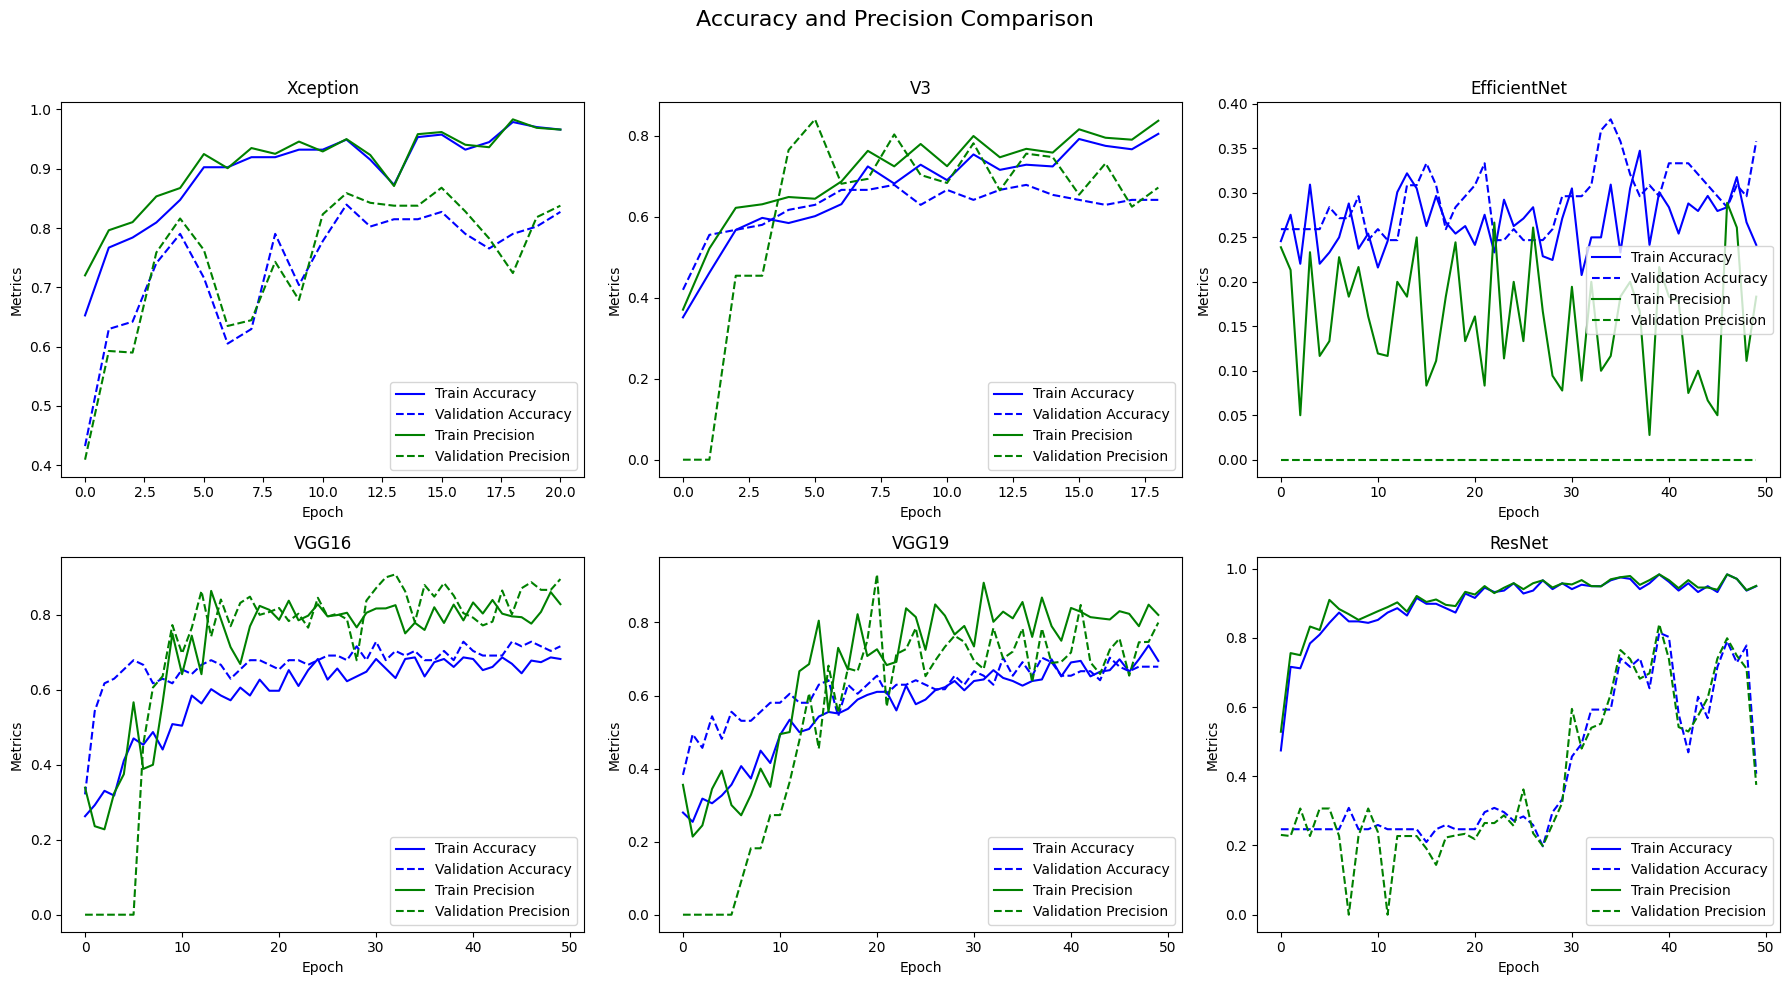

In [55]:
plot_accuracy_and_precision(historias,nombres)

In [69]:
import pandas as pd
from sklearn.metrics import classification_report

def evaluar_modelos(modelos, nombres_modelos, test_generator):
    resultados = {'Modelo': [], 'Precisión': [], 'Recall': [], 'F1': []}

    for modelo, nombre_modelo in zip(modelos, nombres_modelos):
        # Evaluación en el conjunto de prueba
        evaluation = modelo.evaluate(test_generator)

        # Obtener las predicciones para calcular otras métricas
        predictions = modelo.predict(test_generator)

        # Calcular métricas adicionales usando classification_report de scikit-learn
        report = classification_report(test_generator.classes, predictions.argmax(axis=1), target_names=test_generator.class_indices)

        # Obtener las métricas específicas de interés
        precision = evaluation[1]
        recall = float(report.split()[-4])
        f1 = float(report.split()[-2])

        # Almacenar resultados en el diccionario
        resultados['Modelo'].append(nombre_modelo)
        resultados['Precisión'].append(precision)
        resultados['Recall'].append(recall)
        resultados['F1'].append(f1)

    # Crear un DataFrame con los valores de las métricas
    df_resultados = pd.DataFrame(resultados)

    return df_resultados



In [71]:
modelos = [model_resnet, model_vgg19, model_vgg16, model_EfficientNetB0_1, model_V3, xception_model]
nombres_modelos = ['ResNet', 'VGG19', 'VGG16', 'EfficientNetB0_1', 'V3', 'Xception']

df_resultados = evaluar_modelos(modelos, nombres_modelos, test_generator)

# Muestra el DataFrame
print(df_resultados)

11/11 [==============================] - 2s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 3s 219ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 3s 228ms/step
             Modelo  Precisión  Recall    F1
0            ResNet   0.385542    0.12  0.15
1             VGG19   0.602410    0.21  0.20
2             VGG16   0.578313    0.27  0.27
3  EfficientNetB0_1   0.289157    0.18  0.19
4                V3   0.590361    0.29  0.29
5          Xception   0.759036    0.13  0.13


In [72]:
from tabulate import tabulate

def imprimir_tabla(df_resultados):
    print(tabulate(df_resultados, headers='keys', tablefmt='pretty', showindex=False))

# Ejemplo de uso
imprimir_tabla(df_resultados)

+------------------+---------------------+--------+------+
|      Modelo      |      Precisión      | Recall |  F1  |
+------------------+---------------------+--------+------+
|      ResNet      | 0.3855421543121338  |  0.12  | 0.15 |
|      VGG19       | 0.6024096608161926  |  0.21  | 0.2  |
|      VGG16       | 0.5783132314682007  |  0.27  | 0.27 |
| EfficientNetB0_1 | 0.28915661573410034 |  0.18  | 0.19 |
|        V3        | 0.5903614163398743  |  0.29  | 0.29 |
|     Xception     |  0.759036123752594  |  0.13  | 0.13 |
+------------------+---------------------+--------+------+


In [76]:
# Specify the directory to save the models
save_dir = '/content/drive/My Drive/SavedModels'

# Ensure the directory exists, create it if necessary
os.makedirs(save_dir, exist_ok=True)

# Save Xception model
xception_model.save(os.path.join(save_dir, 'xception_model_v2_384x612.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


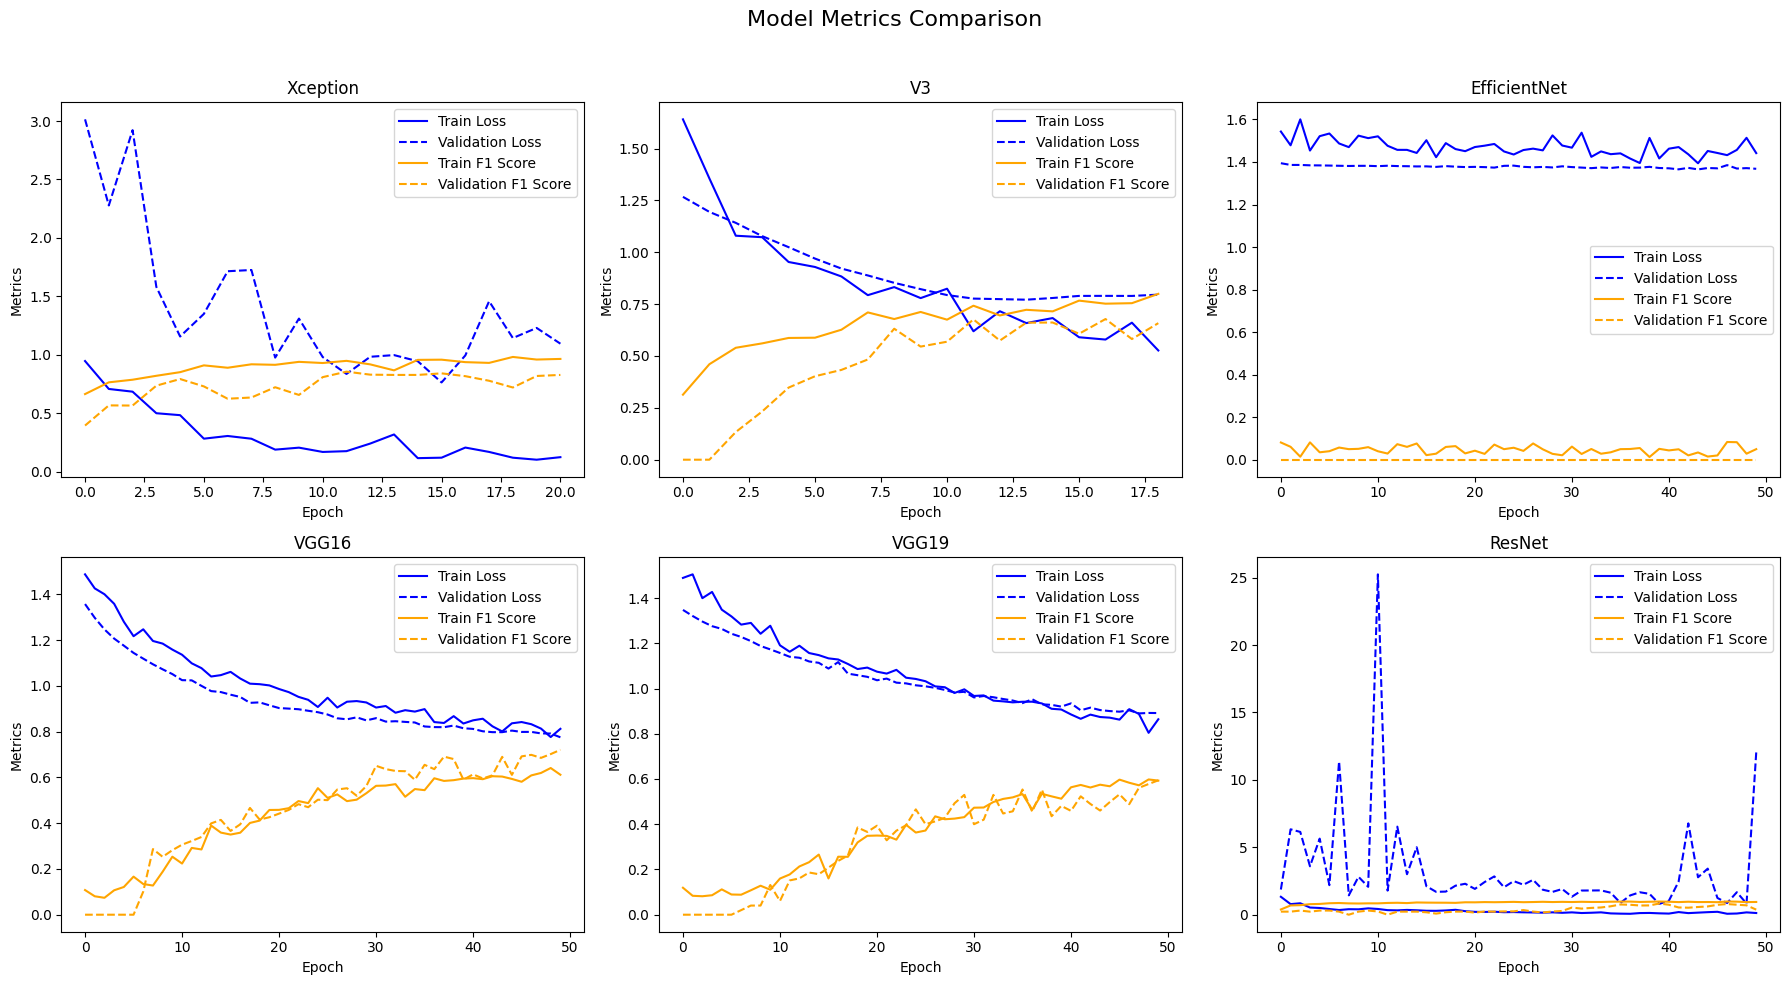

In [56]:
plot_metrics_loss_f1(historias,nombres)

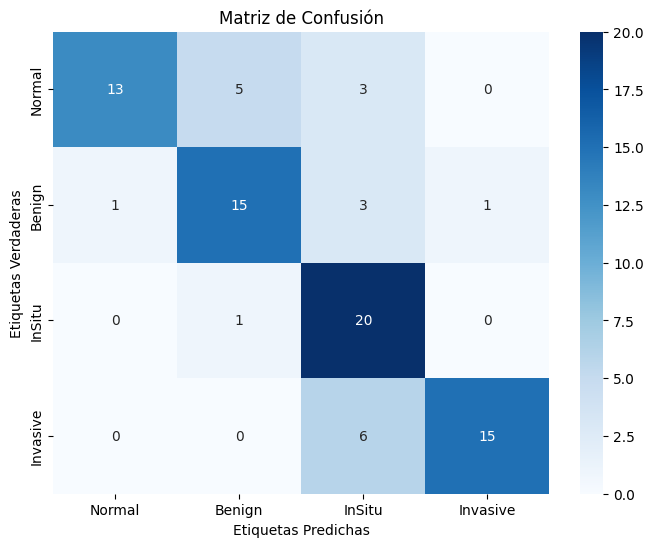

In [45]:
plot_confusion_matrix(cm_xception, classes)
